In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time

from net.aams import AttentionNet, Encoder, Decoder, SelfAttention
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_dir', type=str, default='./datasets/content_set/val2014',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_dir', type=str, default='./datasets/style_set/val2014',
                    help='Directory path to a batch of style images')
parser.add_argument('--mix_dir', type=str, default='./datasets/content_style_mix_set/val2014')

# training options
parser.add_argument('--save_dir', default='./models/',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=80000)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--n_threads', type=int, default=2)
parser.add_argument('--save_model_interval', type=int, default=100)
parser.add_argument('--start_iter', type=float, default=5000)
parser.add_argument('--seperate', type=bool, default=False)
parser.add_argument('--decoder', type=str, default = 'decoder_iter_5000.pth')
parser.add_argument('--attn', type=str, default = 'attention_kernel_iter_5000.pth')
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset(args.content_dir, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size,
    num_workers=args.n_threads)
train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


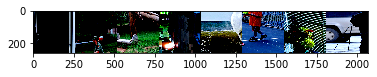

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [6]:
def get_optimizer(model, seperate):
    for param in model.encode.parameters():
        param.requires_grad = False
    if seperate == True:
        optimizer = torch.optim.Adam([
            {'params': model.self_attn_content.parameters()},
            {'params': model.self_attn_style.parameters()},
            {'params': model.content_decode.parameters()},
            {'params': model.style_decode.parameters()},
        ], lr=args.lr)
    else:
        optimizer = torch.optim.Adam([
            {'params': model.decode.parameters()},
            {'params': model.self_attn.parameters()},
        ], lr=args.lr)
    return optimizer

if(args.start_iter > 0):
    decoder = Decoder()
    decoder.load_state_dict(torch.load(args.save_dir+args.decoder))
    attn = SelfAttention()
    attn.load_state_dict(torch.load(args.save_dir+args.attn))
    
    state_dict = decoder.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    state_dict = attn.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    
    model = AttentionNet(seperate=args.seperate, attn=attn, decoder = decoder)
    optimizer = get_optimizer(model, args.seperate)
    optimizer.load_state_dict(torch.load(args.save_dir + 'optimizer_iter_' + str(args.start_iter) + '.pth'))
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
else:
    model = AttentionNet(seperate=args.seperate)
    optimizer = get_optimizer(model, args.seperate)

model.to(device)   
loss_seq = {'total': [], 'construct': [], 'percept': [], 'tv': [], 'attn': []}

In [7]:
def lastest_arverage_value(values, length=100):
    if len(values) < length:
        length = len(values)
    return sum(values[-length:])/length

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    if args.seperate == False:
        content_images = next(train_iter).to(device)
        losses, _, _ = model(content_images)
    total_loss = losses['total']
    
    for name, vals in loss_seq.items():
        loss_seq[name].append(losses[name].item())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        print("%s: Iteration: [%d/%d]\tRecon Loss: %2.4f\tPercept Loss: %2.4f\tTV Loss: %2.4f\tAttn Loss: %2.4f\tTotal: %2.4f"%(time.ctime(),i+1, 
                args.max_iter, lastest_arverage_value(loss_seq['construct']), lastest_arverage_value(loss_seq['percept']), 
                lastest_arverage_value(loss_seq['tv']), lastest_arverage_value(loss_seq['attn']), lastest_arverage_value(loss_seq['total'])))
        if args.seperate == False:
            state_dict = model.decode.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = model.self_attn.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/attention_kernel_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = optimizer.state_dict()
            torch.save(state_dict,
                       '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
        else:
            pass
    
    

  0%|          | 99/75000 [00:34<7:21:14,  2.83it/s]

Sat Jun 27 06:13:00 2020: Iteration: [5100/80000]	Recon Loss: 0.0473	Percept Loss: 3.8366	TV Loss: 0.0589	Attn Loss: 15693.5243	Total: 94166.0444


  0%|          | 199/75000 [01:10<7:23:52,  2.81it/s]

Sat Jun 27 06:13:36 2020: Iteration: [5200/80000]	Recon Loss: 0.0447	Percept Loss: 3.7013	TV Loss: 0.0574	Attn Loss: 14491.5439	Total: 86953.9862


  0%|          | 299/75000 [01:46<7:29:52,  2.77it/s]

Sat Jun 27 06:14:12 2020: Iteration: [5300/80000]	Recon Loss: 0.0452	Percept Loss: 3.6525	TV Loss: 0.0572	Attn Loss: 13641.3338	Total: 81852.6798


  1%|          | 399/75000 [02:22<7:29:00,  2.77it/s]

Sat Jun 27 06:14:48 2020: Iteration: [5400/80000]	Recon Loss: 0.0441	Percept Loss: 3.6428	TV Loss: 0.0575	Attn Loss: 12788.3906	Total: 76735.0019


  1%|          | 499/75000 [02:58<7:28:18,  2.77it/s]

Sat Jun 27 06:15:25 2020: Iteration: [5500/80000]	Recon Loss: 0.0450	Percept Loss: 3.6609	TV Loss: 0.0575	Attn Loss: 11821.4744	Total: 70933.5316


  1%|          | 599/75000 [03:35<7:26:38,  2.78it/s]

Sat Jun 27 06:16:01 2020: Iteration: [5600/80000]	Recon Loss: 0.0454	Percept Loss: 3.7042	TV Loss: 0.0581	Attn Loss: 10771.2510	Total: 64632.2450


  1%|          | 699/75000 [04:11<7:32:13,  2.74it/s]

Sat Jun 27 06:16:37 2020: Iteration: [5700/80000]	Recon Loss: 0.0452	Percept Loss: 3.7313	TV Loss: 0.0583	Attn Loss: 9808.5203	Total: 58855.8885


  1%|          | 799/75000 [04:47<7:33:46,  2.73it/s]

Sat Jun 27 06:17:14 2020: Iteration: [5800/80000]	Recon Loss: 0.0446	Percept Loss: 3.7251	TV Loss: 0.0585	Attn Loss: 8858.9766	Total: 53158.6152


  1%|          | 837/75000 [05:01<7:24:39,  2.78it/s]